Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- А к вещественным применим standardScaler

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Обработаем признаки

In [6]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [7]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь добавим модель, для начала это будет бустинг

In [8]:
from sklearn.ensemble import AdaBoostClassifier

boost = Pipeline([
    ('features',feats),
    ('adaBoost', AdaBoostClassifier(n_estimators=50, learning_rate = 1)),
])

In [9]:
#обучим наш пайплайн
boost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [10]:
#наши прогнозы для тестовой выборки
preds_boost = boost.predict_proba(X_test)[:, 1]
preds_boost[:10]

array([0.49627575, 0.49473083, 0.49017317, 0.4884277 , 0.48533484,
       0.49936197, 0.47819607, 0.47955241, 0.50060094, 0.495391  ])

In [11]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Найдем оптимальный порог и посчитаем метрики

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_boost)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.497405, F-Score=0.626, Precision=0.620, Recall=0.633


Теперь применим модель логистической регресии

In [13]:
from sklearn.linear_model import LogisticRegression

classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [14]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [15]:
#наши прогнозы для тестовой выборки
preds_class = classifier.predict_proba(X_test)[:, 1]
preds_class[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

Посчитаем метрики

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_class)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


По всем метрикам модель на AdaBoost обучилась лучше

Ещё раз посчитаем метрики для бустинга и отрисуем матрицу ошибок

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_boost)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.497405, F-Score=0.626, Precision=0.620, Recall=0.633


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1794  197]
 [ 188  321]]


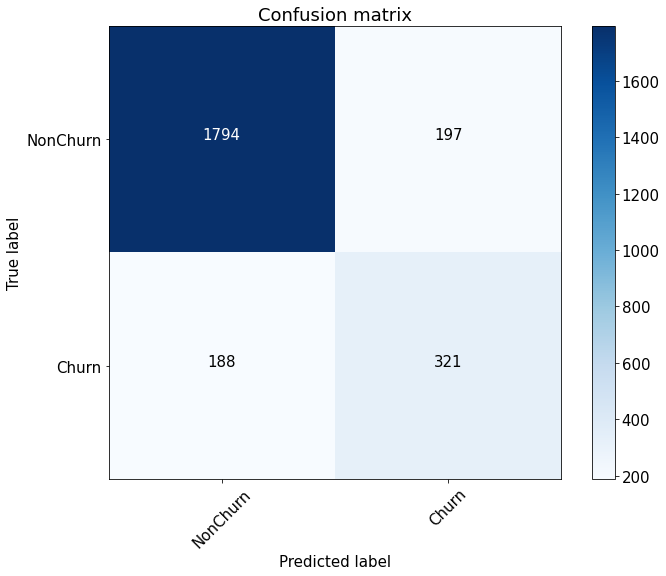

In [19]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_boost>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Сделаем оценку экономической эффективности с учетом что тратим 1 доллар на привлечение и получаем 2 доллара с каждого правильно классифицированного

In [20]:
tp = cnf_matrix[0][0]
fp = cnf_matrix[0][1]
fn = cnf_matrix[1][0]
tn = cnf_matrix[1][1]

tp, fp, fn, tn

(1794, 197, 188, 321)

У нас четыре ситуации:
 - модель верно предсказала отток, это true positive, с каждого правильно предсказаного мы можем заработать по 2 доллара, но потратим по 1 доллару на удержание
 - модель предсказала что пользователь уйдет в отток, но на самом деле пользователь остался, мы теряем по 1 доллару на удержание
 - модель предсказала что пользователь останется, а он ушёл в отток - мы теряем по 2 доллара за каждого пользователя
 - модель предсказала что пользователь останется и он остался - мы ничего не теряем и ничего не зарабатываем

In [22]:
retention = 1
profit = 2

print(f"Выручка: {tp*profit}")
print(f"Траты: {tp*retention + fp * retention + fn * profit}")

print(f"Прибыль: {tp * (profit - retention) - fp * retention - fn * profit}")

Выручка: 3588
Траты: 2367
Прибыль: 1221


Посчитаем прибыль приидельных условиях, когда всё верно предсказали

In [23]:
(tp + fn)*(profit - retention)

1982

Вывод: при текущей модели мы остаёмся в плюсе, но из-за не совсем точного предсказания мы заработали меньше примерно на треть.
Идеальной ситуации быть не может, но я думаю что есть куда стремиться, моё мнение - нужна более эффективная модель, хотя и эта не плохо работает. В конечном итоге на сколько эта модель эффективна должен решать бизнес.